In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from pathlib import Path
import sys
sys.path.insert(0, '..')

import seaborn as sns

### Read in subsets of the data

In [18]:
# Make 10,000 row subsets of the data for checking
!head -10000 ../data/raw/tabular_data.csv > ../data/raw/raw_data_sample.csv
!head -10000 ../data/processed/cleaned_data.csv > ../data/processed/clean_data_sample.csv

In [173]:
dir_raw = Path('../data/raw/raw_data_sample.csv')
dir_clean = Path('../data/processed/clean_data_sample.csv')
dir_arrays = Path('../data/processed/arrays')

In [20]:
raw = pd.read_csv(dir_raw)
clean = pd.read_csv(dir_clean)

In [31]:
# how many pixels?
print("N Pixels in the raw df:   ", len(raw.lat.unique()) * len(raw.lon.unique()))
print("N Pixels in the clean df: ", len(clean.lat.unique()) * len(clean.lon.unique()))

N Pixels in the raw df:    118
N Pixels in the clean df:  120


### Q: What are the columns in the raw / clean data?

In [32]:
raw.columns

Index(['lat', 'lon', 'time', 'lst_night', 'lst_day', 'lst_mean', 'precip',
       'sm', 'spi', 'spei', 'ndvi', 'evi', 'month'],
      dtype='object')

In [35]:
clean.columns

Index(['lat', 'lon', 'time', 'gb_year', 'gb_month', 'lst_night', 'lst_day',
       'precip', 'sm', 'spi', 'spei', 'ndvi', 'evi', 'target'],
      dtype='object')

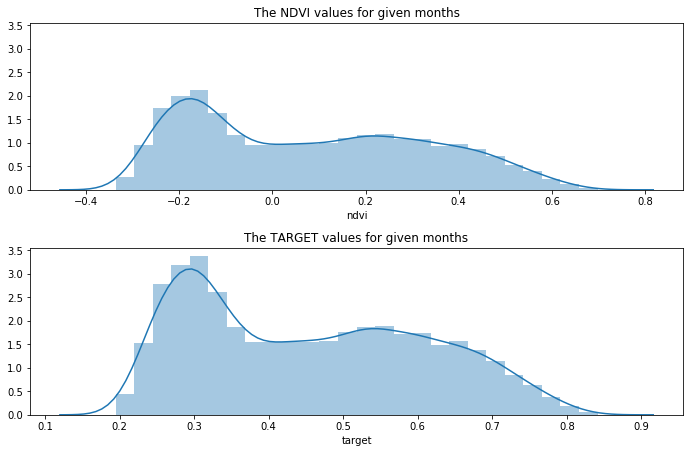

In [121]:
# Target is the NDVI in a given month. NDVI is the value for the preceding months

scale=0.8
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12*scale,8*scale),sharey=True)
sns.distplot(clean.ndvi,ax=ax1);
ax1.set_title("The NDVI values for given months")
sns.distplot(clean.target,ax=ax2);
ax2.set_title("The TARGET values for given months")
plt.tight_layout()

In [36]:
raw.describe()

,lat,lon,lst_night,lst_day,lst_mean,precip,sm,spi,spei,ndvi,evi,month
count,9999.000000,9999.000000,9999.000000,9997.000000,9997.000000,9882.000000,9882.000000,9882.000000,0.0,9999.000000,9999.000000,9999.000000
mean,-4.975002,35.440929,18.568271,31.843388,25.205595,99.012262,0.164807,0.077234,NaN,0.451590,0.278601,6.433843
std,0.000000,1.698028,1.981615,4.478344,2.911857,113.156729,0.058254,0.925314,NaN,0.153160,0.104250,3.482531
min,-4.975002,32.524994,13.190004,20.830185,18.270036,0.000000,0.077165,-2.720334,NaN,0.130450,0.070425,1.000000
25%,-4.975002,33.974991,17.229958,28.330113,23.030011,4.311026,0.112438,-0.542518,NaN,0.313050,0.184597,3.000000
50%,-4.975002,35.425003,18.669887,31.249974,24.880001,58.570936,0.159889,0.023888,NaN,0.433201,0.254300,6.000000
75%,-4.975002,36.925003,19.869958,35.009820,27.180058,163.470202,0.207947,0.691885,NaN,0.578797,0.365446,9.000000
max,-4.975002,38.375000,24.550022,45.009632,33.939949,631.902163,0.382029,5.337272,NaN,0.825000,0.606782,12.000000


In [37]:
clean.describe()

,lat,lon,gb_year,gb_month,lst_night,lst_day,precip,sm,spi,spei,ndvi,evi,target
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,-4.925003,35.551630,2013.479448,6.521052,-0.082939,-0.119308,0.105300,-0.058379,-0.007090,-0.018083,0.077886,0.090982,0.453794
std,0.000000,1.723096,2.054701,3.449364,0.104672,0.182049,0.409148,0.227513,0.243359,0.256846,0.251524,0.242974,0.157125
min,-4.925003,32.574997,2010.000000,1.000000,-0.371169,-0.616976,-0.255129,-0.395146,-0.739521,-1.047344,-0.336869,-0.327779,0.194700
25%,-4.925003,34.074997,2012.000000,4.000000,-0.157405,-0.256977,-0.237010,-0.258962,-0.171601,-0.201298,-0.154053,-0.130573,0.308904
50%,-4.925003,35.574997,2013.000000,7.000000,-0.078156,-0.140977,-0.046341,-0.082171,-0.017007,-0.014796,0.054524,0.046842,0.439200
75%,-4.925003,37.024994,2015.000000,10.000000,-0.011420,0.005427,0.342081,0.098844,0.153286,0.177208,0.285875,0.292359,0.583723
max,-4.925003,38.524994,2017.000000,12.000000,0.238803,0.407823,1.979183,0.735196,1.451091,0.787332,0.698201,0.902721,0.841300


## Q: What does the normalisation process do?
- They have a MEAN of 0
- The value is a ratio of the range of the max/min defined by a given percentile value
- How different from the mean as a ratio of the range between the 97.5pctile and 2.5pctile

```python
@staticmethod
def normalize(series, normalizing_percentile):
    # all features to have 0 mean and a normalized point to point value
    min_percentile = (100 - normalizing_percentile) / 2
    max_percentile = 100 - min_percentile
    ptp = np.percentile(series, max_percentile) - np.percentile(series, min_percentile)
    return (series - series.mean()) / ptp
```

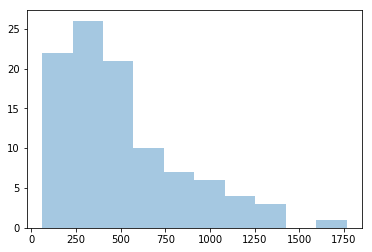

In [103]:
from predictor import CSVCleaner

# test different input distributions
# random_values = (np.random.sample(size=100) * 100) + 10
# random_values = (np.random.normal(0,2,size=100) * 100) + 10
random_values = (np.random.gamma(2,2,size=100) * 100) + 10

sns.distplot(random_values, kde=False)

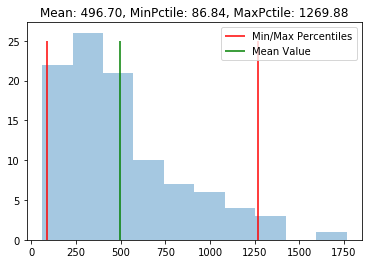

In [106]:
# set the % of values within which you define your 'range'.
normalizing_percentile = 95


min_percentile = (100 - normalizing_percentile) / 2
max_percentile = 100 - min_percentile

# what values correspond to those percentiles?
min_val = np.percentile(random_values, min_percentile)
max_val = np.percentile(random_values, max_percentile)

# what is the range?
ptp = max_val - min_val
# what is the mean
mean = random_values.mean()

fig, ax = plt.subplots()
sns.distplot(random_values, kde=False, ax=ax)

ax.vlines(min_val,ymin=0,ymax=25, color='r', label="Min/Max Percentiles")
ax.vlines(max_val,ymin=0,ymax=25, color='r')
ax.vlines(mean,ymin=0,ymax=25, color='g', label="Mean Value")
 
with np.printoptions(precision=3, suppress=True):
    ax.set_title(f"Mean: {mean:.2f}, MinPctile: {min_val:.2f}, MaxPctile: {max_val:.2f}")
plt.legend();

- So in the above graph, the green line becomes the 0 point and the red lines become the values which define +1, -1.

The Range of Values:  4.196641046054665


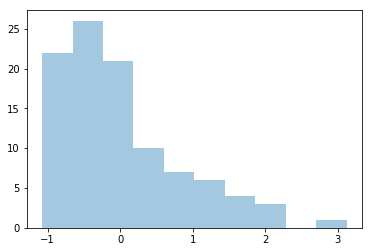

In [105]:
# centered on 0 
cleaner = CSVCleaner()

cleaned = cleaner.normalize(random_values, normalizing_percentile)
sns.distplot(cleaned, kde=False)
# the range max - min (ptp)
print("The Range of Values: ",np.ptp(cleaned))

### Q: Can we turn the data back to xarray?

In [143]:
c = clean.set_index(['lat','lon','time']).to_xarray()
c['time'] = [pd.to_datetime(time) for time in c.time.values]
c

<xarray.Dataset>
Dimensions:    (lat: 1, lon: 120, time: 84)
Coordinates:
  * lat        (lat) float64 -4.925
  * lon        (lon) float64 32.57 32.62 32.68 32.72 ... 38.38 38.43 38.47 38.52
  * time       (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2016-12-01
Data variables:
    gb_year    (lat, lon, time) float64 2.01e+03 2.01e+03 2.01e+03 ... nan nan
    gb_month   (lat, lon, time) float64 7.0 8.0 9.0 10.0 ... nan nan nan nan
    lst_night  (lat, lon, time) float64 -0.03123 -0.05 -0.03749 ... nan nan nan
    lst_day    (lat, lon, time) float64 -0.229 -0.229 -0.2506 ... nan nan nan
    precip     (lat, lon, time) float64 -0.2551 -0.2547 -0.2482 ... nan nan nan
    sm         (lat, lon, time) float64 0.2148 0.204 0.2889 ... nan nan nan
    spi        (lat, lon, time) float64 0.0645 0.1789 0.1301 ... nan nan nan
    spei       (lat, lon, time) float64 0.06675 0.201 0.1176 ... nan nan nan
    ndvi       (lat, lon, time) float64 0.3071 0.4038 0.419 ... nan nan nan
    evi        (lat

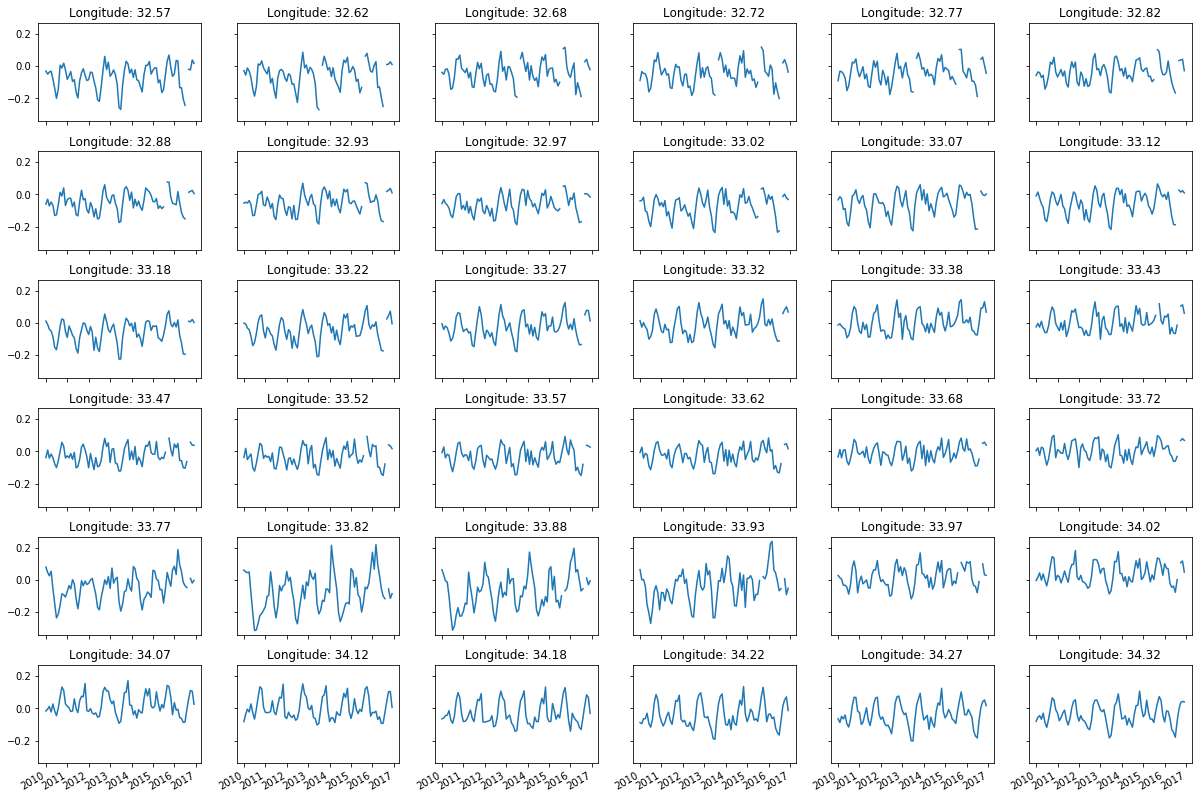

In [170]:
import calendar
months = [_ for _ in calendar.month_name if _ != '']

scale = 1.4
n_plots = (6,6)
fig,axs = plt.subplots(n_plots[0],n_plots[1], figsize=(12*scale,8*scale), sharey=True,sharex=True)

for i in range(n_plots[0] * n_plots[1]):
    ax = axs[np.unravel_index(i,(6,6))]
    c.isel(lon=i).lst_night.plot(ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(f"Longitude: {c.isel(lon=i).lon.values:.2f}")
    
plt.tight_layout()

### Q: What do the numpy arrays look like

In [189]:
x = np.load(dir_arrays/"train"/"x.npy")
y = np.load(dir_arrays/"train"/"y.npy")
yrs = np.load(dir_arrays/"train"/"years.npy")
ll = np.load(dir_arrays/"train"/"latlon.npy")

x_tst = np.load(dir_arrays/"test"/"x.npy")
y_tst = np.load(dir_arrays/"test"/"y.npy")
yrs_tst = np.load(dir_arrays/"test"/"years.npy")
ll_tst = np.load(dir_arrays/"test"/"latlon.npy")

In [177]:
# Pixel-Years, N_Months, N_Features
x.shape

(290658, 11, 8)

In [184]:
# Pixel-Years
y.shape
yrs.shape

# Pixel-Years, (lat,lon)
ll.shape

(290658, 2)

In [188]:
print("Training Data")
print("Unique Years: ",np.unique(yrs))
print("N Unique LatLons: ", len(np.unique(ll)))

Training Data
Unique Years:  [2011 2012 2013 2014 2015]
N Unique LatLons:  680


In [190]:
print("Training Data")
print("Unique Years: ",np.unique(yrs_tst))
print("N Unique LatLons: ", len(np.unique(ll_tst)))

Training Data
Unique Years:  [2016]
N Unique LatLons:  680
